In [1]:
%pylab inline
# next 2 lines allow to automatically reload modules that have been changed externally
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.insert(0, '/nobackup/jakravit/smartg-dev/smartg/')
from luts.luts import LUT, MLUT, Idx, merge, read_mlut

from smartg.albedo import Albedo_spectrum, Albedo_speclib, Albedo_cst
from smartg.bandset import BandSet
from smartg.smartg import Smartg, Sensor, multi_profiles, reduce_diff
from smartg.smartg import RoughSurface, LambSurface, FlatSurface, Environment, multi_profiles
from smartg.atmosphere import AtmAFGL, AeroOPAC, CompOPAC, CloudOPAC, diff1, read_phase, Species, trapzinterp
from smartg.water import IOP_1, IOP, IOP_profile, IOP_Rw, IOP_base
from smartg.reptran import REPTRAN, reduce_reptran
#from smartg.kdis import KDIS, reduce_kdis
from smartg.tools.tools import SpherIrr, Irr, reduce_Irr
from smartg.tools.cdf import ICDF
from smartg.tools.phase import integ_phase, calc_iphase

from smartg.tools.smartg_view import compare, plot_polar, spectrum , mdesc 
from smartg.tools.smartg_view import spectrum_view,transect_view,profile_view,phase_view,smartg_view,input_view
import warnings

from scipy.interpolate import interp1d
warnings.filterwarnings("ignore")

from smartg_int_library import *
from build_Case2 import build_Case2
import numpy as np
from scipy.interpolate import interp1d
import pickle
import pandas as pd
import uuid
import time

# Data paths 

outpath = '/nobackup/jakravit/data/RTM_outputs/'
aux_dir = '/nobackup/jakravit/smartg-dev/smartg/smartg/tools/'
datadir = '/nobackup/jakravit/data/'

# phytoplankton SIOP spectral library
# path = '/nobackup/jakravit/data/EAP_phytoplankton_dataset/'
phy_library = {'Haptophytes': {}, 
               'Diatoms': {},
               'Dinoflagellates': {},
               'Cryptophytes': {},
               'Green_algae': {},
               'Cyano_blue': {},
               'Heterokonts': {},
               'Cyano_red': {},
               'Rhodophytes': {}
               }

for phy in phy_library:
    print (phy)
    with open(datadir+'EAP_phytoplankton_dataset/'+phy+'.p', 'rb') as fp:
        phy_library[phy] = pickle.load(fp)

# NAP spectral libraries
minpath = datadir+'EAP_NAP_dataset/minerals_V2.p'
with open(minpath, 'rb') as fp:
    datamin = pickle.load(fp)  

detpath = datadir+'EAP_NAP_dataset/det_V1.p'
with open(detpath, 'rb') as fp:
    datadet = pickle.load(fp) 

# Benthic library
benthic_lib = pd.read_csv(datadir+'benthic_spec_libary_FT_V4.csv')

# adjacency library
adj_lib = pd.read_csv(datadir+'adjacency_spectra_V2.csv')

# aeronet library
aero_lib = pd.read_csv(datadir+'aeronet_invdata_match.csv')


Populating the interactive namespace from numpy and matplotlib
Haptophytes
Diatoms
Dinoflagellates
Cryptophytes
Green_algae
Cyano_blue
Heterokonts
Cyano_red
Rhodophytes


In [1]:
snames = []
inputs = []
toa = []
boa = []
INFO = True
alis=False

#----------------------------- START BUILDING ---------------------------------#

# Case
sname_title = 'case2_test'

# how many runs to build
runs = 1

# lambda
# l = np.arange(400, 902.5, 2.5)  
# Static data : IOPs wavelength grids
WAV = np.linspace(400, 900., num=201, dtype=np.float32)
WAV_CDOM = np.arange(240., 900., 2.5, dtype=np.float32)

# for k in range(runs):
# start = time.time()
# print ('BatchID: {}'.format(k))

# initiate iop dict
iops, cols, row = build_Case2(phy_library, datamin, datadet, benthic_lib, adj_lib, aero_lib)
if INFO:
# print ('RunID: {}'.format(uuid))
# print ('COMPONENTS:')
# for key in iops.keys():
#     print (key)
    print ('Chla: {} ug/L'.format(iops['Phyto']['TotChl']))
    print ('Minl: {} g/L'.format(iops['Min']['Tot_conc']))
    print ('ag440: {} m^-1'.format(iops['CDOM']['ag440']))
    print ('Max Depth: {} m'.format(iops['Depth']['Dmax']))
    print ('Water radius: {} km'.format(iops['Adjacency']['water_radius']))
    print ('Dist from shore: {} km'.format(iops['Adjacency']['dist']))


NameError: name 'np' is not defined

In [9]:

# get mixing IOP's
ap1,ac1,bp1,vsf1,angles = mix(iops)
aw, bw = read_awbw(aux_dir, WAV)

# wavelength grid/slice for absorption and scattering coefficients
# wavelength grid for outputs
wavrange = slice(0,202,2)
wav      = WAV[wavrange]
# wav      = np.arange(400,905,5)
# wavelength grid/slice for scattering matrices
wavrange_vsf = slice(0,200,20)
wav_vsf      = WAV[wavrange_vsf]
# vertical grid
Z = iops['Depth']['Depth']
# Z   = np.array([0, -2.5, -5., -10.])
xfactor = iops['Depth']['xfactor']
zeros = np.zeros_like(wav)

#IOP's profiles
bp_list = [bp1[wavrange] * x for x in xfactor] 
ap_list = [ap1[wavrange] * x for x in xfactor]
ac_list = [ac1[wavrange] * x for x in xfactor]
xfactorvsf = [1 if x==0 else x for x in xfactor]
vsf_list = [vsf1[:,wavrange_vsf,:] * x for x in xfactorvsf]
aw_list = [aw[wavrange]] * len(xfactor)
bw_list = [bw[wavrange]] * len(xfactor)
# aw_list = None # use SMART-G default pure water absorption
# bw_list = None # use SMART-G default pure water scattering

# Albedos speclib library inputs    
bALB = Albedo_spectrum2(iops['Benthic']['Tot'])
aALB = Albedo_speclib2(iops['Adjacency']['Tot'])

# water MLUT building
# VSF truncation at 10 deg
# seafloor from mixing model
water   = import_iop(ap_list, bp_list, ac_list, vsf_list, wav, wav_vsf, Z, angles, 
                    aw_list=aw_list, bw_list=bw_list, ang_trunc=10.,  ALB=bALB)

# Ocean surface
surf=RoughSurface(WAVE_SHADOW=True, WIND=iops['Atm']['wind'])

# Land environment
D       = iops['Adjacency']['water_radius'] #(km)
# The Environement object creates a disk of ocean surface with radius ENV_SIZE
# centred on X0,Y0 , surrounded by lambertian reflector of albedo ALB
env     = Environment(ENV=1, 
                      ENV_SIZE= D ,       # radius of the circle with ocean surface condition
                      X0= -D,             # X coordinate of the center of the circle
                      Y0= 0,
                      ALB=aALB # adjacency mixing model
                     )

#Observer
HTOA   = 120.
VZA    = iops['Atm']['VZA']
VAA    = iops['Atm']['VAA']
dist   = iops['Adjacency']['dist'] # distance to the coast(km)
DeltaH = HTOA   * np.tan(np.radians(VZA))
DeltaX = DeltaH * np.cos(np.radians(180-VAA))
DeltaY = DeltaH * np.sin(np.radians(180-VAA))
sensor_TOA = Sensor(
    POSX = -dist + DeltaX,      # Sensor coordinates (in km) (default:origin(0.,0.,0.))
    POSY = DeltaY,
    POSZ = HTOA,
    THDEG= 180-VZA, # Sensor 'Emitting' zenith angle, from 0: Zenith to 180.: Nadir (default:0.)
    PHDEG= VAA,     # Sensor 'Emitting' azimuth angle (default:0.)
    LOC  = 'ATMOS', # location of sensor (default: (SURF0P, just above surface)
    FOV  = 0.,      # Sensor FOV (default 0.)
    TYPE = 0        # Sensor type :Radiance (0), Planar flux (1), Spherical Flux (2), (default 0)
    )
sensor_BOA = Sensor(THDEG=180-VZA, PHDEG=VAA, TYPE=0, LOC='ATMOS')

# Atmosphere
# to be computed at eh same wavlegnth grid as water IOP's

# monochromatic computation for custom aerosols and cloud
wlref = 440.
# Aerosols and cloud optical properties using OPAC database as processed by the the libradtran (www.libradtran.org)
aer = AeroOPAC( iops['Atm']['aero_prof'], 
                iops['Atm']['aero'].loc[:,'AOD_Coincident_Input[440nm]'].values, 
                wlref,
                ssa = iops['Atm']['aero'].loc[:,'Single_Scattering_Albedo[440nm]'].values
              ) 


atm = AtmAFGL(atm_filename = iops['Atm']['atm_prof'],    # atmosphere profile
              comp=[aer], # no clouds, only aerosols          
              #O3 = 0.,   # scale ozone vertical column to 0 Dobson units (here no absoprtion by ozone)
              #NO2= False,# disable absorption by NO2
              #H2O= 2.,   # scale water vapour column to 2 g/cm-2, but no H2O absoprtion, just hygroscopic computation for aerosols
              #P0 = 980., # set sea level pressure to 980 hPa
              #tauR=0.1,   # force Rayleigh optical thickness
              #grid =   [100., 75., 50., 25., 15., 10., 5., 3., 2., 1.15], # set vertical grid, surface altitude at 1.15 km
              #pfgrid = [100., 25., 15., 10., 5., 3., 2., 1.15], # vertical grid for the computation of particles phase functions
              pfwav=wav_vsf
             ).calc(wav)

le  = {'th_deg':np.linspace(30,60,num=3), 'phi_deg':np.linspace(0,360,num=9)}

if alis:
    S = Smartg(alt_pp=True, double=True, alis=alis,)
    alis_options={'nlow':31} 
else:
    S = Smartg(device=0, back=True, alt_pp=False, alis=alis)
    alis_options=None


# Compile with the alis options
# then run specifying the alis_options dictionary
# main keyword is 'nlow' , the number of low spectral resolution computation
# of the scattering correction terms: specify -1 for all wavelengths

# mB =Smartg(device=0, back=True, alt_pp=False, alis=alis).run(wl=wav, water=water, 
#                                 atm=atm, surf=surf, 
#                                 NBPHOTONS=1e7, sensor=sensor_TOA, NF=1e3, alis_options=alis_options,
#                                 le=le, OUTPUT_LAYERS=3,)

mB =S.run(wl=wav, water=water, atm=atm, surf=surf, NBPHOTONS=1e7, sensor=sensor_TOA, NF=1e3, 
              alis_options=alis_options, le=le, OUTPUT_LAYERS=3,)


Box(children=(FloatProgress(value=0.0, max=10000000.0), Label(value='')), layout=Layout(align_items='center', …

<AxesSubplot:ylabel='TOA ref'>

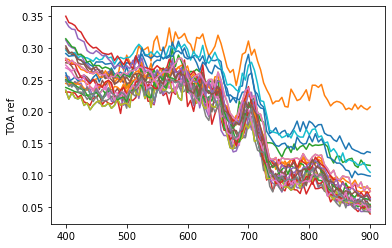

In [10]:
outputs = []
iup = mB[0]
za = np.linspace(30,60,num=3)
aa = np.linspace(0,360,num=9)

for k in range(len(za)):
    for j in range(len(aa)):
        toa = []
        for i in range(len(wav)):
            toa.append(iup[i,j,k])
        outputs.append(toa)

outputs = pd.DataFrame(outputs, columns=wav)
# fig, ax = plt.subplots()
outputs.T.plot(legend=False,ylabel='TOA ref')

In [ ]:
#     for k in range(len(za)):
#         for j in range(len(aa)):
#             np.append(row, k)
#             np.append(row, j)
#             np.append(cols, za[k])
#             np.append(cols, aa[j])
#             inputs.append(row)
#             snames.append(uuid.uuid4().hex)
#             toa_ref = []
#             boa_ref = []
#             for i in range(len(wav)):
#                 toa_ref.append(iup[i,j,k])
#                 boa_ref.append(iup0[i,j,k])
#             toa.append(toa_ref)
#             boa.append(boa_ref)
#     end = time.time()
#     np.append(row, end-start)
#     np.append(cols, 'time')

# inputs = pd.DataFrame(inputs,columns=cols,index=snames)
# toa = pd.DataFrame(toa,columns=wav,index=snames)
# boa = pd.DataFrame(boa,columns=wav,index=snames)

# # save case batch
# outpath2 = '{}{}/'.format(outpath,sname_title)
# if os.path.exists(outpath2):
#     pass
# else:
#     os.mkdir(outpath2)
# inputs.to_csv(outpath2+'{}_inputs.csv'.format(sname_title))
# toa.to_csv(outpath2+'{}_toa.csv'.format(sname_title))
# boa.to_csv(outpath2+'{}_boa.csv'.format(sname_title))
              
# print ('DONE!')